# Abalone



Abalone is a mollusc with a peculiar ear-shaped shell lined of mother of pearl. Its age can be estimated counting the number of rings in their shell with a microscope, but it is a time consuming process, in this tutorial we will use Machine Learning to predict the age using physical measurements.

This is an example of a regression problem where we are predicting a number.  


# Introduction

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
import numpy as np
from ast import literal_eval
import re
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sklearn.model_selection import train_test_split

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()

# S3 bucket where the training data is located.
data_prefix = "datasets/tabular/uci_abalone"

print(f"REGION:  {region}")
print(f"ROLE:    {role}")
print(f"BUCKET:  {bucket_name}")

REGION:  us-east-1
ROLE:    arn:aws:iam::431615879134:role/sagemaker-test-role
BUCKET:  sagemaker-us-east-1-431615879134


In [57]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',
                   header=None, names=['sex', 'length', 'diameter', 'height', 'weight', 'shucked_weight',
                                       'viscera_weight', 'shell_weight', 'rings'])

In [58]:
df

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [59]:
df['sex'] = (df['sex']=='M').astype(int)

In [60]:
df.describe()

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.365813,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.481715,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,1.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


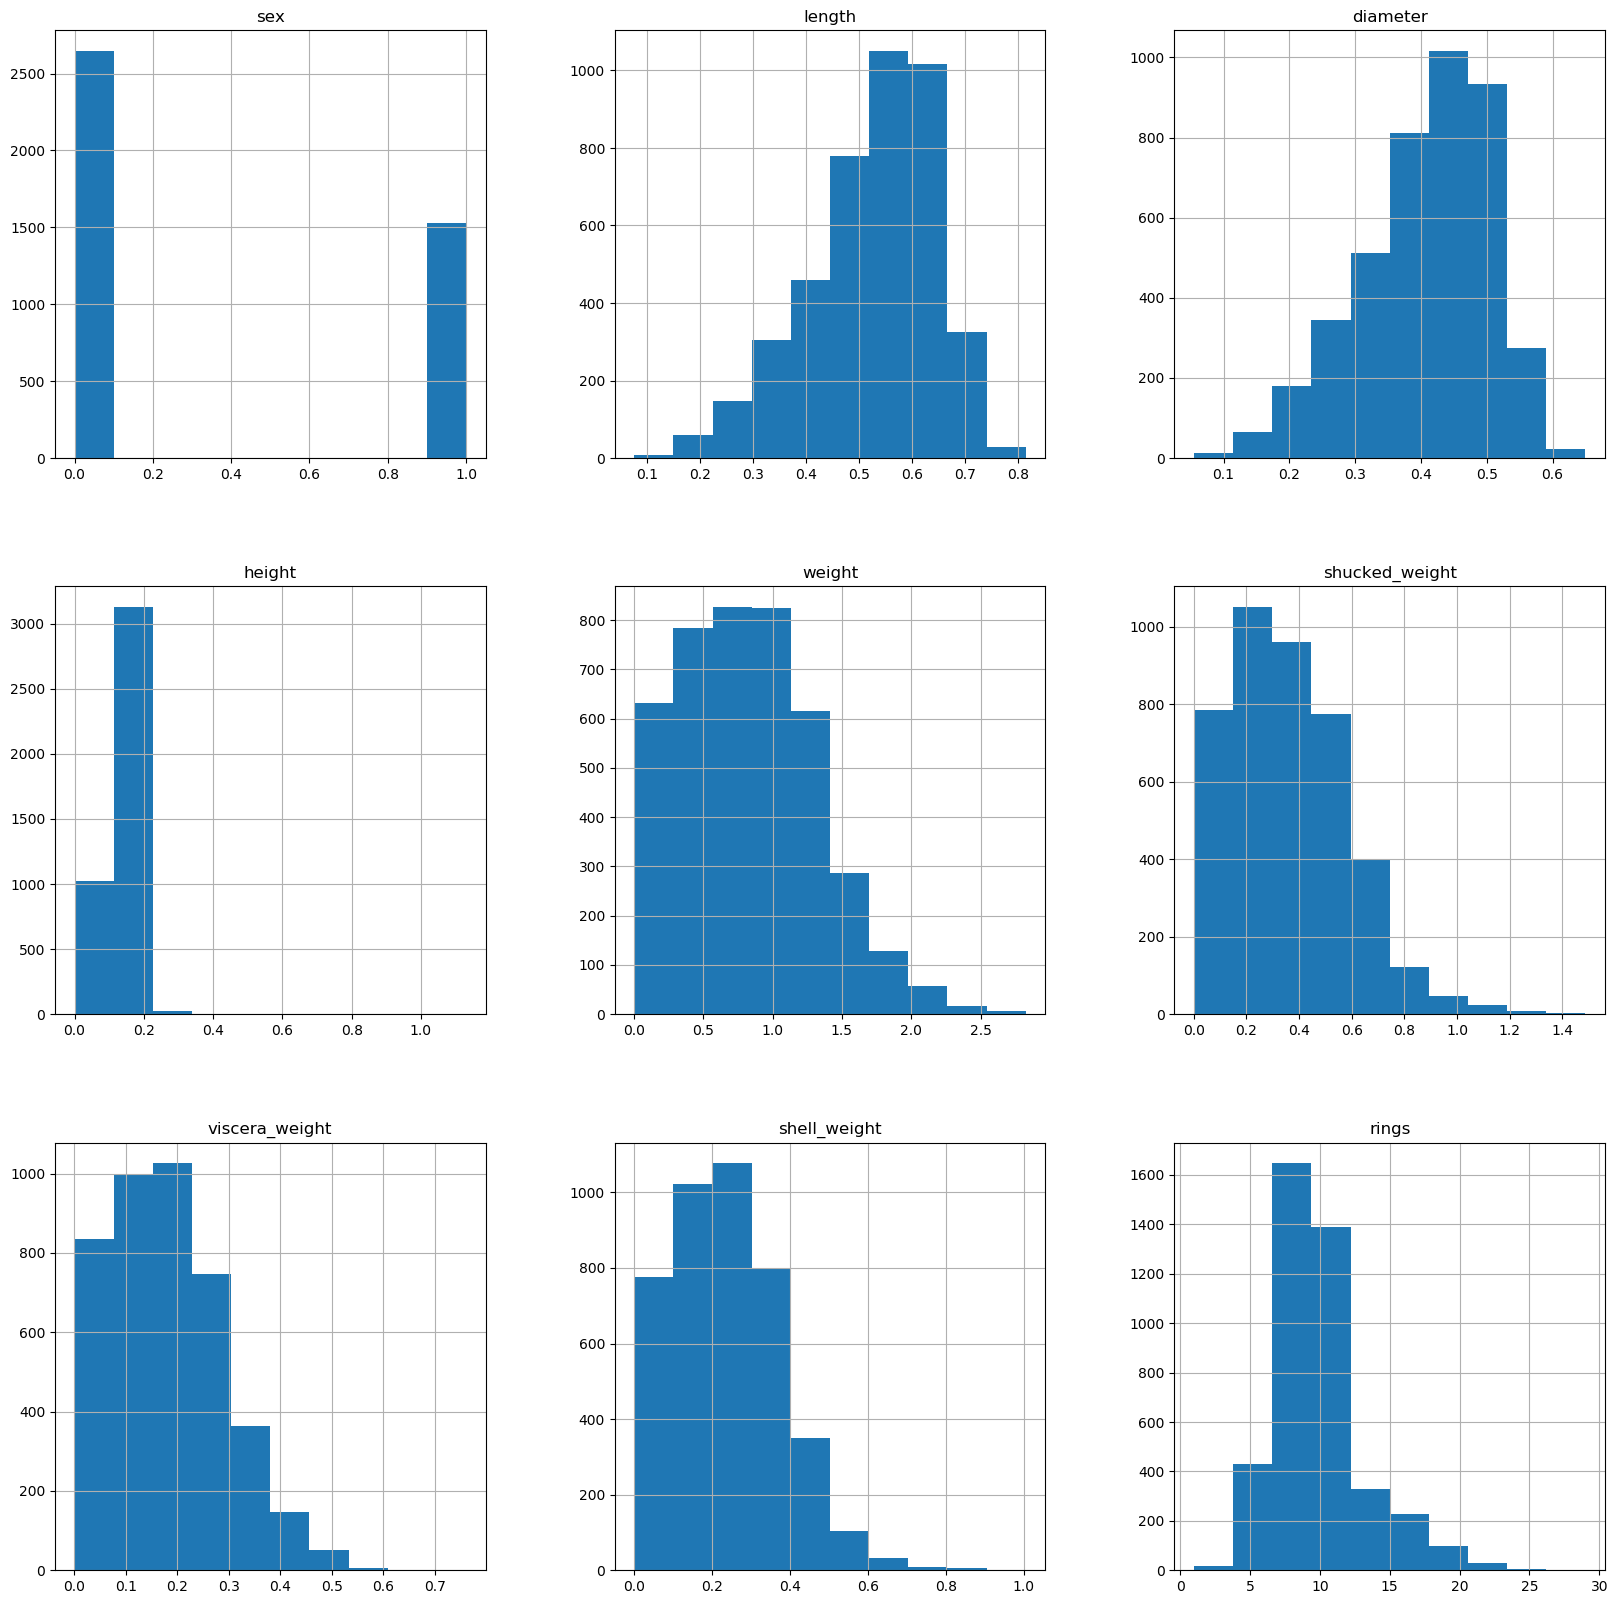

In [61]:
df.hist(figsize=(20,20))
plt.show()

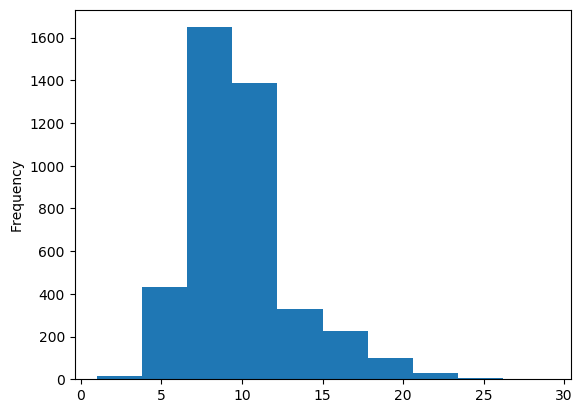

In [62]:
df['rings'].plot.hist()
plt.show()

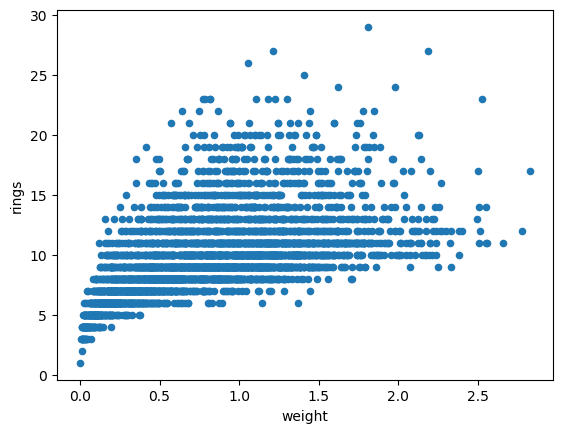

In [63]:
df.plot.scatter('weight', 'rings')
plt.show()

In [73]:
df.to_csv('./data/abalone.data',header=False,index=False)

In [74]:
s3path = sagemaker_session.upload_data('./data/abalone.data',bucket=bucket_name,key_prefix=data_prefix)

In [75]:
s3_input_data = sagemaker.inputs.TrainingInput(s3_data=s3path, content_type='csv')

# Training

In [76]:
output_path = f's3://{bucket_name}/{data_prefix}/output/'
FRAMEWORK_VERSION = "1.2-1"

In [77]:
output_path

's3://sagemaker-us-east-1-431615879134/datasets/tabular/uci_abalone/output/'

In [80]:
estimator = SKLearn(
    entry_point="randomforest.py",
    source_dir='./code/',
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[
        {"Name": "RMSE", "Regex": "RMSE is: ([0-9.]+).*$"},
        {"Name": "MAPE", "Regex": "MAPE is: ([0-9.]+).*$"}
    ],
    output_path=output_path,
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 5
    }
)

In [82]:
estimator.fit({'data': s3_input_data})

INFO:sagemaker:Creating training-job with name: rf-scikit-2023-07-10-17-21-16-138


Using provided s3_resource
2023-07-10 17:21:16 Starting - Starting the training job...
2023-07-10 17:21:33 Starting - Preparing the instances for training......
2023-07-10 17:22:30 Downloading - Downloading input data...
2023-07-10 17:23:11 Training - Training image download completed. Training in progress....
2023-07-10 17:23:47 Uploading - Uploading generated training model
2023-07-10 17:23:47 Completed - Training job completed
2023-07-10 17:23:30,694 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-07-10 17:23:30,697 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-10 17:23:30,706 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-07-10 17:23:30,923 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-10 17:23:30,936 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-10 17:23:30,948 sagemaker-

# deploy

In [83]:
# split data into training and validation
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=54321, 
    shuffle=True, 
)

In [86]:
val_y = val_df.iloc[:,-1].values
val_x = val_df.iloc[:,0:-1].values

In [84]:
predictor = estimator.deploy(initial_instance_count=2,instance_type='ml.m5.2xlarge')

INFO:sagemaker:Creating model with name: rf-scikit-2023-07-10-17-29-31-520
INFO:sagemaker:Creating endpoint-config with name rf-scikit-2023-07-10-17-29-31-520
INFO:sagemaker:Creating endpoint with name rf-scikit-2023-07-10-17-29-31-520


----!

In [89]:
val_x[0]

array([0.    , 0.545 , 0.435 , 0.135 , 0.7715, 0.372 , 0.148 , 0.227 ])

In [96]:
result = predictor.predict(val_x[0].reshape(1, -1))
print(result)
print(val_y[0])

[8.95037589]
8


In [ ]:
predictor.delete_endpoint()

# batch

We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

In [97]:
# Define an SKLearn Transformer from the trained SKLearn Estimator
transformer = estimator.transformer(instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker:Creating model with name: rf-scikit-2023-07-10-17-38-24-500


In [98]:
val_df.iloc[:,0:-1].to_csv('./data/batch.csv',header=False,index=False)

In [99]:
s3path = sagemaker_session.upload_data('./data/batch.csv',bucket=bucket_name,key_prefix=data_prefix)


## Run Transform Job

Using the Transformer, run a transform job on the S3 input data.


In [100]:
# Start a transform job and wait for it to finish
transformer.transform(s3path, content_type="text/csv")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: rf-scikit-2023-07-10-17-41-30-497


............................2023-07-10 17:46:10,376 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2023-07-10 17:46:10,379 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2023-07-10 17:46:10,379 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      retu

In [102]:
# Download the output data from S3 to local file system
batch_output = transformer.output_path
batch_output

's3://sagemaker-us-east-1-431615879134/rf-scikit-2023-07-10-17-41-30-497'

In [106]:
!aws s3 cp --recursive $batch_output/ data/batch_output/

download: s3://sagemaker-us-east-1-431615879134/rf-scikit-2023-07-10-17-41-30-497/batch.csv.out to data/batch_output/batch.csv.out


In [116]:
with open('./data/batch_output/batch.csv.out','r') as f:
    preds = f.read()
preds = np.array(literal_eval(preds))

In [105]:
from sklearn.metrics import mean_squared_error

In [117]:
mean_squared_error(val_y,preds)

5.144116435436259